<a href="https://colab.research.google.com/github/jiho-kang/DL_CNN_Study/blob/main/03_Conv_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

### Conv2D 적용하기
* Conv2D() 를 모델에 적용 시에는 반드시 입력은 배치 크기를 제외하고 3차원이 되어야 함(즉 배치를 포함하면 4차원)  

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

input_tensor = Input(shape=(28, 28, 1)) # 지금은 gray니까 1이고, color 이미지는 기본적으로 마지막에 3이 들어간다.
x = Conv2D(filters=4, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
print('x type:', type(x))
print('x:', x)

x type: <class 'keras.engine.keras_tensor.KerasTensor'>
x: KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 4), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")


### Pooling 적용하기

In [ ]:
input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = MaxPooling2D(2)(x)
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 16), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")


### CNN 모델 생성
- 이제는 flatten 잘 안쓰고, GlobalAveragePooling2D를 사용함. 일단 flatten 먼저 진행하고 나중에 공부할거임.

In [ ]:
input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
print(x)
x = MaxPooling2D(2)(x)

model = Model(inputs=input_tensor, outputs=x)
model.summary()

# 파라미터 갯수
# ( 커널사이즈 * 커널사이즈 * 커널 갯수(=depth =채널) * 필터 갯수 ) + bias
# 320 = (3 * 3 * 1 * 32) + 32
# 18496 = (3 * 3 * 32 * 64) + 64

KerasTensor(type_spec=TensorSpec(shape=(None, 26, 26, 64), dtype=tf.float32, name=None), name='conv2d_9/Relu:0', description="created by layer 'conv2d_9'")
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_______________________________

In [ ]:
from tensorflow.keras.layers import Dense, Flatten

input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x) # 여기까지 x는 배치를 제외하고 3차원임.

# 3차원으로 되어있는 Feature map 결과를 Fully Connected 연결하기 위해서는 Flatten()을 적용해야함. 
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 100)               1081700   
                                                           

### Fashion MNIST 데이터 전처리후 모델 학습
이전 fashion-mnist-practice.ipynb에서 학습한 코드

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 전체 6만개 데이터 중, 5만개는 학습 데이터용, 1만개는 테스트 데이터용으로 분리
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

def get_preprocessed_data(images, labels):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


# Fashion MNIST 데이터 재 로딩 및 전처리 적용하여 학습/검증/데이터 세트 생성. 

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_labels.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(51000, 28, 28) (51000, 10) (9000, 28, 28) (9000, 10) (10000, 28, 28) (10000,)


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=1000, epochs=30, validation_data=(val_images, val_oh_labels))

Epoch 1/30
51/51 [==============================] - 11s 30ms/step - loss: 0.7094 - accuracy: 0.7514 - val_loss: 0.4488 - val_accuracy: 0.8360
Epoch 2/30
51/51 [==============================] - 1s 26ms/step - loss: 0.3951 - accuracy: 0.8615 - val_loss: 0.3794 - val_accuracy: 0.8656
Epoch 3/30
51/51 [==============================] - 1s 27ms/step - loss: 0.3316 - accuracy: 0.8843 - val_loss: 0.3308 - val_accuracy: 0.8816
Epoch 4/30
51/51 [==============================] - 1s 27ms/step - loss: 0.3010 - accuracy: 0.8933 - val_loss: 0.3221 - val_accuracy: 0.8837
Epoch 5/30
51/51 [==============================] - 1s 26ms/step - loss: 0.2682 - accuracy: 0.9048 - val_loss: 0.2864 - val_accuracy: 0.9006
Epoch 6/30
51/51 [==============================] - 1s 26ms/step - loss: 0.2477 - accuracy: 0.9116 - val_loss: 0.2863 - val_accuracy: 0.8960
Epoch 7/30
51/51 [==============================] - 1s 27ms/step - loss: 0.2304 - accuracy: 0.9174 - val_loss: 0.2587 - val_accuracy: 0.9074
Epoch 8/30
5

### 모델 성능 평가

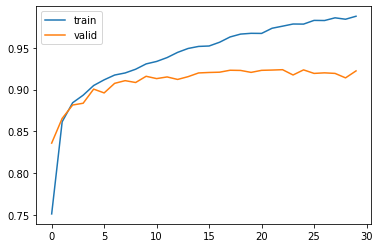

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

In [ ]:
# 테스트 데이터 세트로 모델 성능 검증
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

40/40 [==============================] - 0s 5ms/step - loss: 0.3178 - accuracy: 0.9202


[0.31778231263160706, 0.920199990272522]

### Dropout을 적용하여 Fully Connected Layer의 오버피팅 조정
* CNN은 일반적으로 Dense Layer보다는 파라미터수(weight 수) 작음
* 하지만 많은 Filter 들을 적용하고 이를  Fully Connected Layer로 연결 시 파라미터 수가 늘어남. 
- 즉, CNN은 Feature Extraction 이후 FC에 연결할 때 Flatten한 Weight에서 과적합이 많이 생기게 된다.
* So, Flatten() 이후 Dropout을 적용하여 특정 비율로 FC Layer 연결을 누락 적용.
- 이후에는 Flatten말고 GlobaelAverage2D를 쓸거임.


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout

input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x) # 50% 떨어뜨림
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

# model의 summary에는 param이 0.5 떨어지지 않았지만 실제 학습은 0.5 dropout이 된 상태로 진행됨.

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0         
                                                                 
 dropout_1 (Dropout)         (None, 10816)             0         
                                                           

In [ ]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=1000, epochs=30, validation_data=(val_images, val_oh_labels))

Epoch 1/30
51/51 [==============================] - 2s 32ms/step - loss: 0.7439 - accuracy: 0.7389 - val_loss: 0.4682 - val_accuracy: 0.8327
Epoch 2/30
51/51 [==============================] - 1s 27ms/step - loss: 0.4142 - accuracy: 0.8548 - val_loss: 0.3817 - val_accuracy: 0.8631
Epoch 3/30
51/51 [==============================] - 1s 26ms/step - loss: 0.3600 - accuracy: 0.8722 - val_loss: 0.3394 - val_accuracy: 0.8783
Epoch 4/30
51/51 [==============================] - 1s 27ms/step - loss: 0.3273 - accuracy: 0.8835 - val_loss: 0.3260 - val_accuracy: 0.8821
Epoch 5/30
51/51 [==============================] - 1s 27ms/step - loss: 0.3078 - accuracy: 0.8908 - val_loss: 0.2992 - val_accuracy: 0.8939
Epoch 6/30
51/51 [==============================] - 1s 27ms/step - loss: 0.2812 - accuracy: 0.9008 - val_loss: 0.2872 - val_accuracy: 0.8947
Epoch 7/30
51/51 [==============================] - 1s 28ms/step - loss: 0.2640 - accuracy: 0.9047 - val_loss: 0.2686 - val_accuracy: 0.9037
Epoch 8/30
51

40/40 [==============================] - 0s 5ms/step - loss: 0.2247 - accuracy: 0.9260


[0.22473905980587006, 0.9259999990463257]

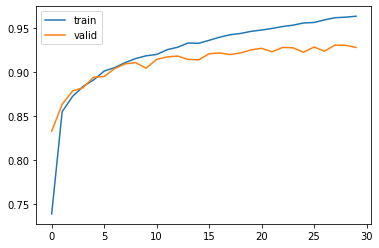

In [ ]:
show_history(history)
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)
# 0.9202 -> 0.9260

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

def create_model():
    input_tensor = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
    x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(2)(x)

    x = Dropout(rate=0.5)(x)
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(200, activation='relu')(x)
    X = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

model = create_model()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 10816)             0         
                                                           

In [ ]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=1000, epochs=30, validation_data=(val_images, val_oh_labels))

Epoch 1/30
51/51 [==============================] - 3s 39ms/step - loss: 0.7217 - accuracy: 0.7423 - val_loss: 0.4358 - val_accuracy: 0.8417
Epoch 2/30
51/51 [==============================] - 2s 31ms/step - loss: 0.4076 - accuracy: 0.8539 - val_loss: 0.3524 - val_accuracy: 0.8749
Epoch 3/30
51/51 [==============================] - 2s 30ms/step - loss: 0.3613 - accuracy: 0.8701 - val_loss: 0.3207 - val_accuracy: 0.8841
Epoch 4/30
51/51 [==============================] - 2s 31ms/step - loss: 0.3305 - accuracy: 0.8813 - val_loss: 0.2942 - val_accuracy: 0.8937
Epoch 5/30
51/51 [==============================] - 2s 31ms/step - loss: 0.3068 - accuracy: 0.8891 - val_loss: 0.2805 - val_accuracy: 0.8998
Epoch 6/30
51/51 [==============================] - 2s 31ms/step - loss: 0.2878 - accuracy: 0.8953 - val_loss: 0.2661 - val_accuracy: 0.9029
Epoch 7/30
51/51 [==============================] - 2s 30ms/step - loss: 0.2780 - accuracy: 0.8990 - val_loss: 0.2611 - val_accuracy: 0.9034
Epoch 8/30
51

40/40 [==============================] - 0s 5ms/step - loss: 0.2011 - accuracy: 0.9310


[0.2011445164680481, 0.9309999942779541]

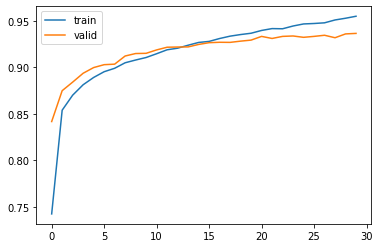

In [ ]:
show_history(history)
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)
# 0.9202 -> 0.9260 -> 0.9310

### 입력 이미지는 배치를 포함하여 4차원이 되어야 함(즉 배치를 제외하면 3차원)
- fashion_mnist는 다운로드 받으면 사실 배치 포함 3차원임.</br>
Conv2D()는 입력으로 배치를 제외하고 3차원 입력이 되어야 함. 
* 하지만 2차원으로 입력해도 Input(shape=(28, 28, 1)) 에서 3차원으로 변경함. 
* 명확하게는 2차원 Grayscale이미지더라도 입력 numpy 이미지 배열에서 배치를 제외한 3차원 입력을 만들어 주는게 좋음. 

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print('before reshape:', train_images.shape, test_images.shape)
train_images = np.reshape(train_images, (60000, 28, 28, 1))
test_images = np.reshape(test_images, (10000, 28, 28, 1))
print('after reshape:', train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_labels.shape)

before reshape: (60000, 28, 28) (10000, 28, 28)
after reshape: (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)
(51000, 28, 28, 1) (51000, 10) (9000, 28, 28, 1) (9000, 10) (10000, 28, 28, 1) (10000,)


In [ ]:
from tensorflow.keras.optimizers import Adam

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=1000, epochs=30, validation_data=(val_images, val_oh_labels))

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 10816)             0         
                                                           

40/40 [==============================] - 0s 5ms/step - loss: 0.2011 - accuracy: 0.9321


[0.20112952589988708, 0.9320999979972839]

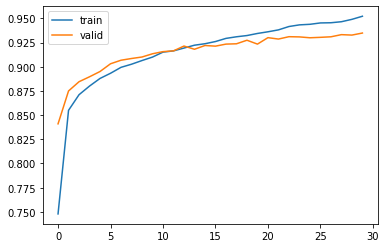

In [ ]:
show_history(history)
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

### Stride가 1이고 Padding이 없는 경우
* I는 입력 Feature Map의 크기, F는 Filter의 크기(Kernel size), P는 Padding(정수), S는 Strides(정수)
* O = (I - F + 2P)/2 + 1 = (5 - 3 + 0 )/1 + 1 = 3

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

input_tensor = Input(shape=(5, 5, 1))
x = Conv2D(filters=1, kernel_size=3, strides=1)(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 3, 3, 1)


### Stride가 1이고 Padding이 1인 경우
* O = (I - F + 2P)/2 + 1 = (5 - 3 + 2 )/1 + 1 = 5

In [ ]:
input_tensor = Input(shape=(5, 5, 1))
x = Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 5, 5, 1)


In [ ]:
# ZeroPadding2D Layer를 이용하여 padding을 수동으로 적용. 
from tensorflow.keras.layers import ZeroPadding2D

input_tensor = Input(shape=(5, 5, 1))
padded_input = ZeroPadding2D(padding=1)(input_tensor)
print('shape after padding:', padded_input.shape)
x = Conv2D(filters=1, kernel_size=3, strides=1)(padded_input)
print('x.shape:', x.shape)


shape after padding: (None, 7, 7, 1)
x.shape: (None, 5, 5, 1)


### Stride가 2이고 Padding이 없는 경우 
* O = (I - F + 2P)/2 + 1 = (5 - 3)/2 + 1 = 2

In [ ]:
input_tensor = Input(shape=(5, 5, 1))
x = Conv2D(filters=1, kernel_size=3, strides=2)(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 2, 2, 1)


### Stride가 2이고 Padding은 1 적용
* O = (I - F + 2P)/2 + 1 = (5 - 3 + 2)/2 + 1 = 3

In [ ]:
input_tensor = Input(shape=(5, 5, 1))
padded_input = ZeroPadding2D(padding=1)(input_tensor)
print('shape after padding:', padded_input.shape)
x = Conv2D(filters=1, kernel_size=3, strides=2)(padded_input)
print('x.shape:', x.shape)

shape after padding: (None, 7, 7, 1)
x.shape: (None, 3, 3, 1)


### 입력이 6X6에서 Stride가 2 적용
* O = (I - F + 2P)/2 + 1 = (6 - 3 + 0)/2 + 1 = 2.5 = 2

In [ ]:
input_tensor = Input(shape=(6, 6, 1))
x = Conv2D(filters=1, kernel_size=3, strides=2)(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 2, 2, 1)


In [ ]:
input_tensor = Input(shape=(6, 6, 1))
x = Conv2D(filters=1, kernel_size=3, strides=2, padding='same')(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 3, 3, 1)


In [ ]:
input_tensor = Input(shape=(6, 6, 1))
padded_input = ZeroPadding2D(padding=1)(input_tensor)
x = Conv2D(filters=1, kernel_size=3, strides=2, padding='valid')(padded_input)
print('x.shape:', x.shape)

x.shape: (None, 3, 3, 1)


In [ ]:
input_tensor = Input(shape=(6, 6, 1))
padded_input = ZeroPadding2D(padding=((1, 0),(1,0)))(input_tensor)
x = Conv2D(filters=1, kernel_size=3, strides=2)(padded_input)
print('x.shape:', x.shape)

x.shape: (None, 3, 3, 1)


### Maxpooling 적용

In [ ]:
input_tensor = Input(shape=(223, 223, 1))
x = MaxPooling2D(2)(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 111, 111, 1)
